In [35]:
cd /home/soda/rcappuzz/work/benchmark-join-suggestions

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
import tarfile

In [38]:
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [39]:
def pivot_based_on_value(melted_df, variable):
    pivoted = melted_df.filter(pl.col("variable") == variable).to_pandas().pivot_table(
        values="value",
        index=["base_table", "aggregation"],
        columns=["estimator", "variable"],
        aggfunc="mean",
    )
    display(pivoted.style.background_gradient(axis=1, cmap="RdYlGn").format(precision=3))

In [40]:
def melt_table(df):
    melted = df.melt(
        id_vars=["base_table", "estimator", "aggregation"],
        value_vars=["r2score", "n_cols", "time_fit", "time_predict", "time_run"],
    )
    return melted

# Depleted table

Run: `0170-fjxndnzl`

In [41]:
run_name = "0170-fjxndnzl"
df_raw = read_logs(run_name)

In [42]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "base_table",
            "estimator",
            "aggregation",
            "r2score",
            "n_cols",
            "time_fit",
            "time_predict",
            "time_run",
        ]
    )
)

In [43]:
melted = melt_table(df_)

In [44]:
pivot_based_on_value(melted, "r2score")

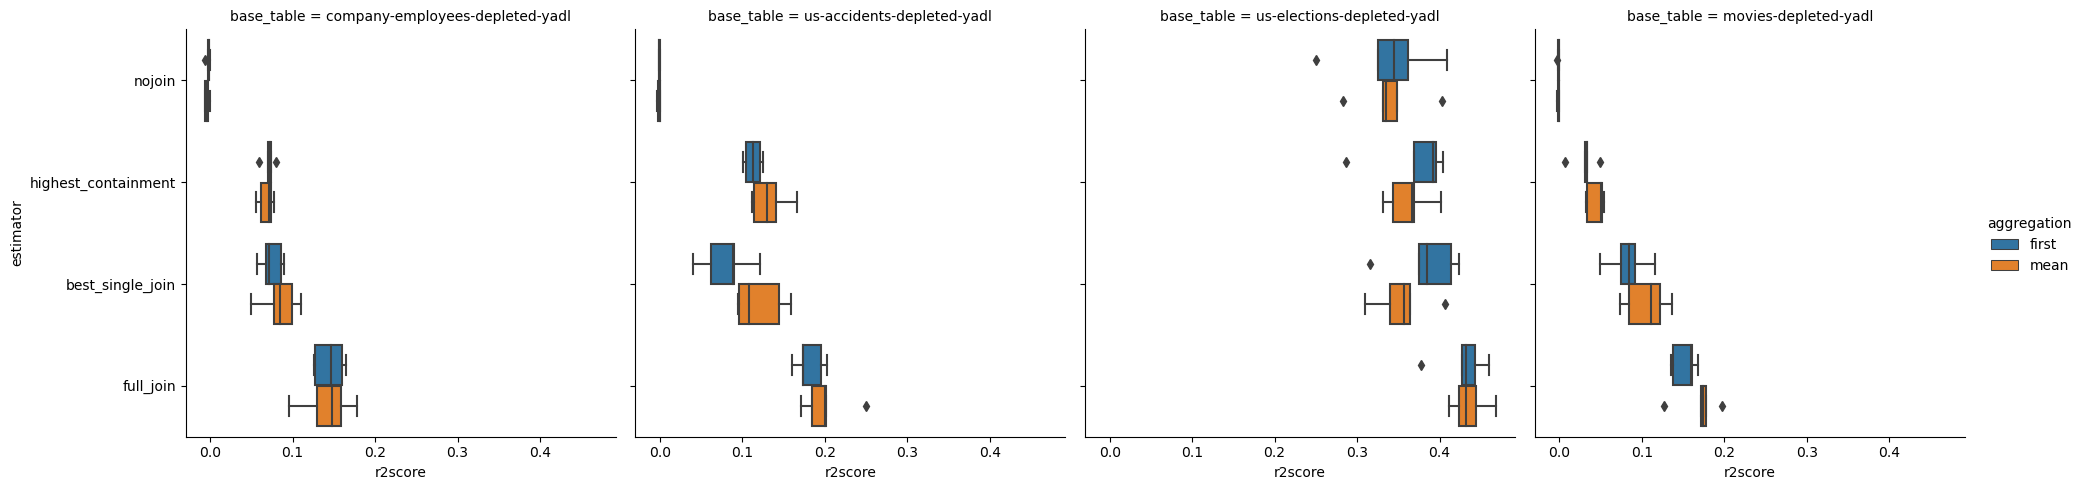

In [45]:
sns.catplot(data=df_raw.to_pandas(), x="r2score", y="estimator", hue="aggregation", kind="box", col="base_table")

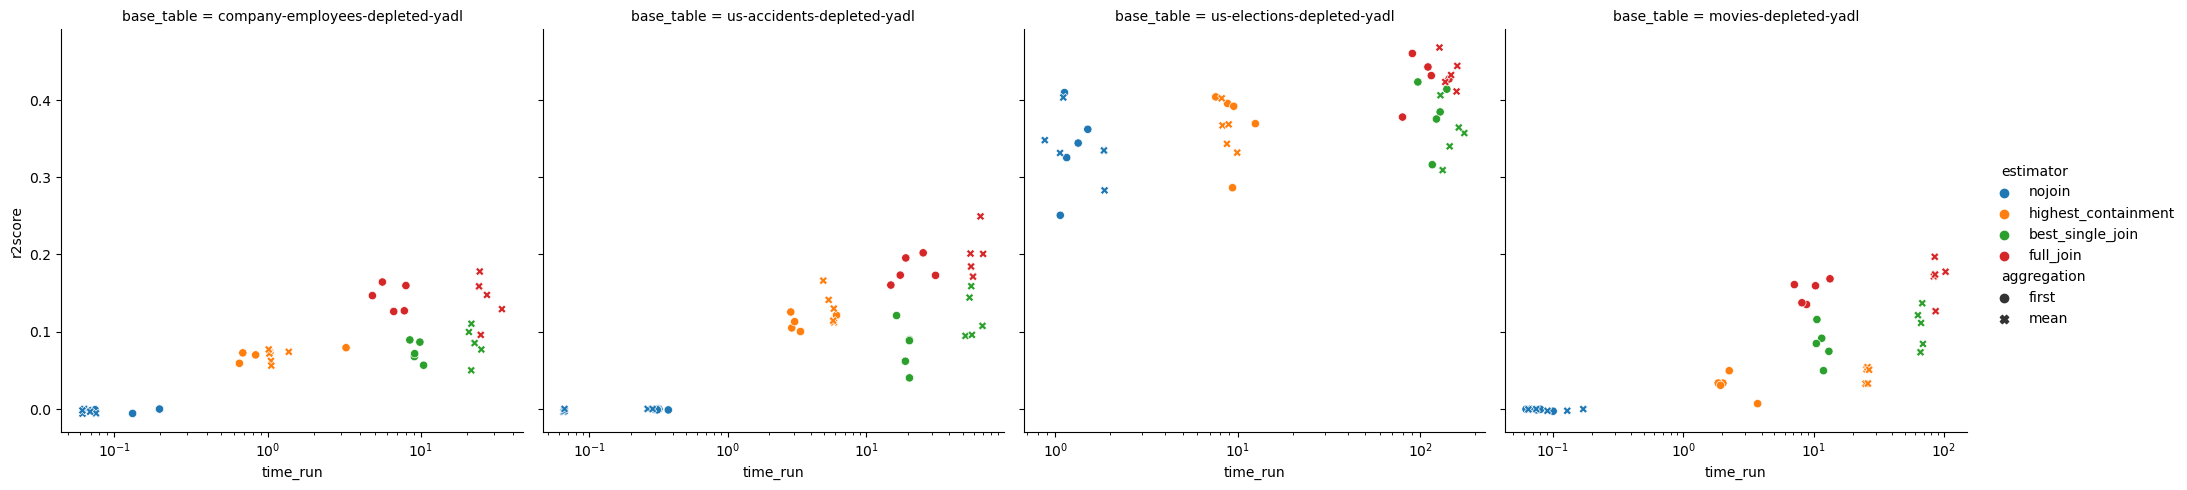

In [46]:
sns.relplot(data=df_raw.to_pandas(), x="time_run", y="r2score", style="aggregation", col="base_table", hue="estimator", kind="scatter", facet_kws={"sharex":False, "subplot_kws":{"xscale":"log"}}, )

# Full table

In [47]:
run_name = "0172-kwhnazxb"
df_raw = read_logs(run_name)

In [48]:
df_ = df_raw.select(
    pl.col(
        [
            "scenario_id",
            "base_table",
            "estimator",
            "aggregation",
            "r2score",
            "n_cols",
            "time_fit",
            "time_predict",
            "time_run",
        ]
    )
)

In [49]:
melted = melt_table(df_)

In [50]:
pivot_based_on_value(melted, "r2score")

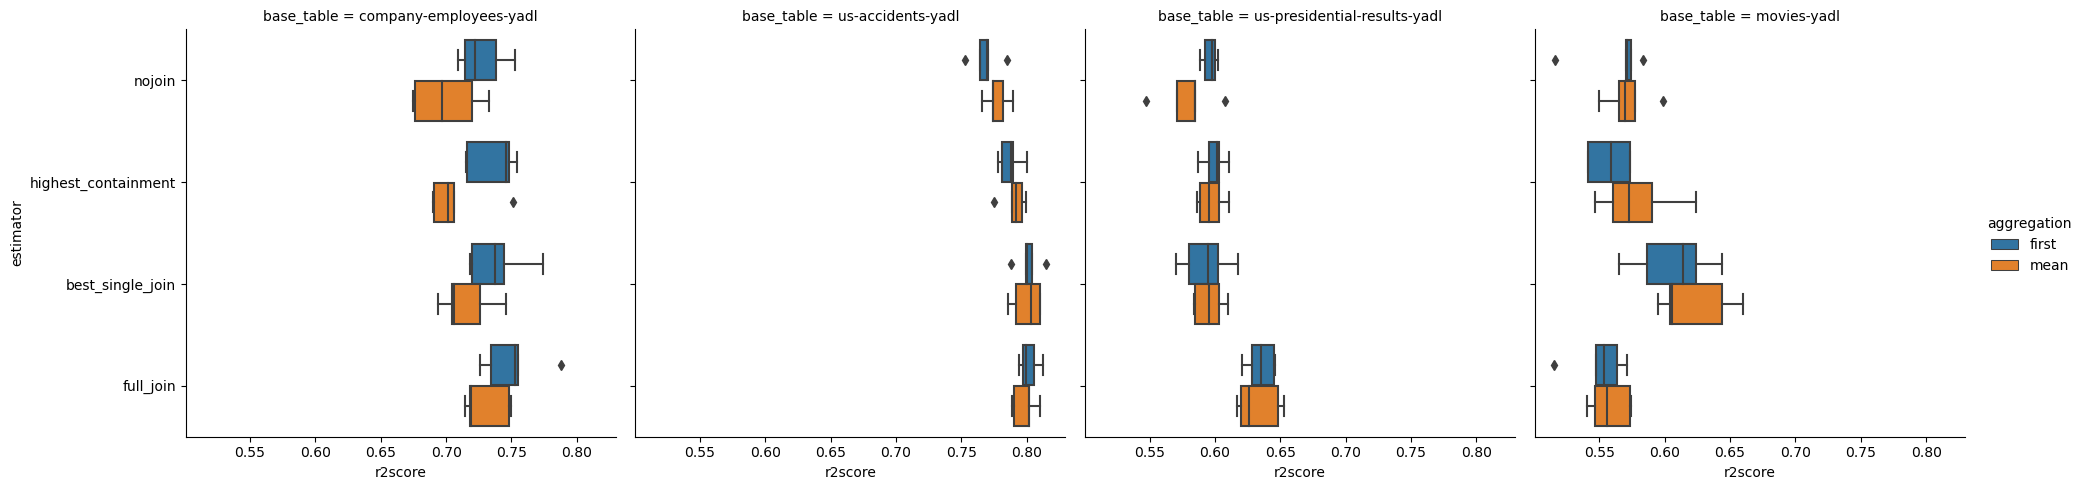

In [51]:
sns.catplot(data=df_raw.to_pandas(), x="r2score", y="estimator", hue="aggregation", kind="box", col="base_table")

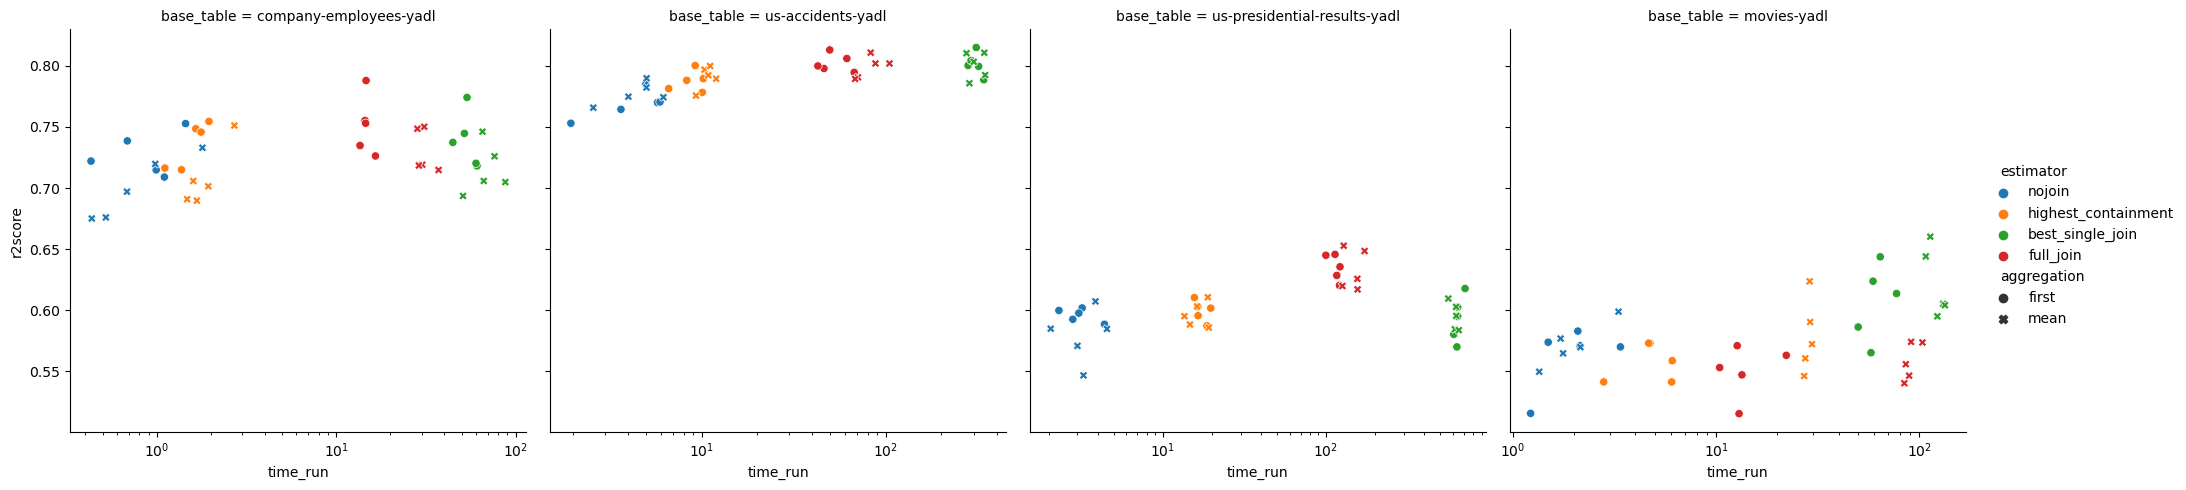

In [52]:
sns.relplot(data=df_raw.to_pandas(), x="time_run", y="r2score", style="aggregation", col="base_table", hue="estimator", kind="scatter", facet_kws={"sharex":False, "subplot_kws":{"xscale":"log"}}, )